# TAFC 2025 Quantum Computing - Exercise Class

#### From ```Numpy``` to ```Qiskit``` and back again
____

This Jupyter notebook (hosted on [Colab](https://colab.google/)) is the main reference for the class of 13th March 2025.

Authors: [Óscar Amaro](https://github.com/OsAmaro), [L. I. Iñigo Gamiz](https://github.com/linigoga)

Link to course page: https://fenix.tecnico.ulisboa.pt/disciplinas/TAFC/2024-2025/2-semestre

**Outline of notebook**:
- 1. [Setup](#section1) (+5 minutes)
- 2. [Qiskit](#section2) (+20 minutes)
- 3. [Useful tools for Physics](#section3) (+20 minutes)
- 4. [Computational Physics](#section4) (+20 minutes)
- 5. [Web Plot Digitizer](#section5) (+5 minutes)
- 6. [Exercise](#section6) (+30 minutes)
- 7. [Conclusions](#section7)

**Obs:** Make sure to copy this notebook to your own **Colab** account, and run it and edit it there: `File` > `Save a Copy in Drive`

### [§1. Setup:](#section1)
- Optionally: instead of running the notebook on ```Colab```, you can download it and create a local virtual environment on your computer (eg. ```python3 -m venv TAFC2025qc```) to install ```Numpy```, ```Scipy```, ```Matplotlib```, ```qiskit```, etc. This will simplify when solving the last exercise.

Using ```venv```: https://docs.python.org/3/library/venv.html

In [2]:
# We make sure these packages are installed

#!pip install numpy
#!pip install matplotlib
#!pip install scipy
!pip install qiskit
#!pip install qiskit-algorithms
!pip install qiskit-aer
!pip install pylatexenc

print()

In [3]:
import numpy as np
import qiskit
import matplotlib
import scipy

from numpy import exp
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator, SparsePauliOp, random_unitary, Statevector
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from scipy.linalg import expm
import operator

In [4]:
# Print versions of installed libraries
print(f"Qiskit Version: {qiskit.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"SciPy Version: {scipy.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")

Qiskit Version: 1.4.1
NumPy Version: 1.26.4
SciPy Version: 1.14.1
Matplotlib Version: 3.10.0


### [§2. Qiskit:](#section1)

Outline:
- Complex vector, normalize wavefunction: ```qc.initialize```
- QFT matrix: comparing with Numpy implementation matrix. Checking that QFT of uniform superposition is sin/x and that a Gaussian is a Gaussian with an inverse spread: ```qiskit.circuit.library.QFT```
- Converting a circuit into a unitary Numpy matrix: ```Operator(qc).data```
- Example of sampling circuits / measuring probabilities: ```AerSimulator()```, ```.get_counts()```
- Hadamard Test, modularity of quantum circuits: turning a previous circuit into a new big gate, and applying to a subset of qubits
  
Notes:
- Ordering of qubits in qiskit is different than the standard ```qc.reverse_bits()```
- Extracting the statevector's complex amplitudes would not be efficient on a real quantum computer
- Turning a unitary matrix into a gate is more difficult than the reverse (would need an explicit 1-2 qubit gate decomposition)

### Initial wavefunction
> Suppose we want to load/initialize the wavefunction according to some specific state.

Loading a Numpy array as the initial state (of course this is not like this in practice, as the loading itself must be a sequence of unitary operations).

In [5]:
# define arbitrary 2^2 wavefunction
psi0 = np.array([ 1, -2j, 3, 4j ])

print("sum |psi0|^2=", np.sqrt( np.sum(np.abs(psi0)**2) ) )
print("np.linalg.norm=", np.linalg.norm(psi0) )

sum |psi0|^2= 5.477225575051661
np.linalg.norm= 5.477225575051661


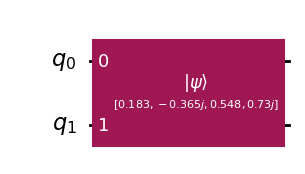

In [6]:
# start quantum circuit
qc = QuantumCircuit(2)  # 2

# Step 1: initialize psi0 at qubits [0,1]. normalize
qc.initialize(psi0, [0,1], normalize=True)

qc.draw('mpl')

### The CNOT gate
> simplest 2-qubit gate producing entanglement

Unitary matrix representation of the CNOT gate with control on qubit 0:
[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]


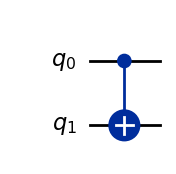

In [7]:
# check qiskit's definition of CNOT gate: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CXGate

# Create a 2-qubit quantum circuit
qc = QuantumCircuit(2)

# Apply the CNOT gate (control: qubit 0, target: qubit 1)
qc.cx(0, 1)

# Use Qiskit's unitary simulator to extract the matrix representation
unitary_matrix = Operator(qc).data

# Display the matrix
print("Unitary matrix representation of the CNOT gate with control on qubit 0:")
print( np.int32(np.real(np.round(unitary_matrix, decimals=3))) )  # Rounded for better readability

qc.draw(output='mpl')

Unitary matrix representation of the CNOT gate with control on qubit 1:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]


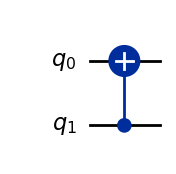

In [8]:
# check qiskit's definition of CNOT gate: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CXGate

# Create a 2-qubit quantum circuit
qc = QuantumCircuit(2)

# Apply the CNOT gate (control: qubit 0, target: qubit 1)
qc.cx(1, 0)

# Use Qiskit's unitary simulator to extract the matrix representation
unitary_matrix = Operator(qc).data

# Display the matrix
print("Unitary matrix representation of the CNOT gate with control on qubit 1:")
print( np.int32(np.real(np.round(unitary_matrix, decimals=3))) )  # Rounded for better readability

qc.draw(output='mpl')

### Quantum Fourier Transform (QFT)
> One of the main subroutines in quantum computing
- Wikipedia article: https://en.wikipedia.org/wiki/Quantum_Fourier_transform
- Example from the Qiskit textbook (no longer maintained): https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

In [9]:
# choose a number of qubits
n = 5

# grid size
N = 2**n

#
def qft_matrix(N):
    """Returns the NxN Quantum Fourier Transform matrix."""
    omega = np.exp(2j * np.pi / N)
    return np.array([[omega**(i * j) for j in range(N)] for i in range(N)]) / np.sqrt(N)

# Generate theoretical QFT matrix
U_numpy = qft_matrix(2**n)

# Generate QFT circuit using Qiskit's built-in function
qc = QFT(n, do_swaps=True)  # `do_swaps=True` ensures correct ordering
U_qiskit = Operator(qc).data # convert to Numpy array

# Compare entry by entry
print("same matrix?", np.allclose(U_qiskit, U_numpy))

# exercise: try comparing with your own implementation of the QFT circuit

same matrix? True


### Quantum Random Numbers and Distribution Sampling
> Quantum measurements should be have perfect randomness (in theory, if ran on idealized quantum hardware). Check also [here](https://github.com/RePlasma/PlaneWaveSampler/blob/main/PlaneWaveSampler.ipynb)

Here we show an example with ```qiskit_aer``` of sampling directly the Probability Distribution Function (PDF) of $\sin^2(k x)$ or $\cos^2(k x)$ distributions. To avoid sampling a flat distribution, we need to conditionally "uncompute" double the phase in each qubit, depending on the measurement of an auxiliary qubit.

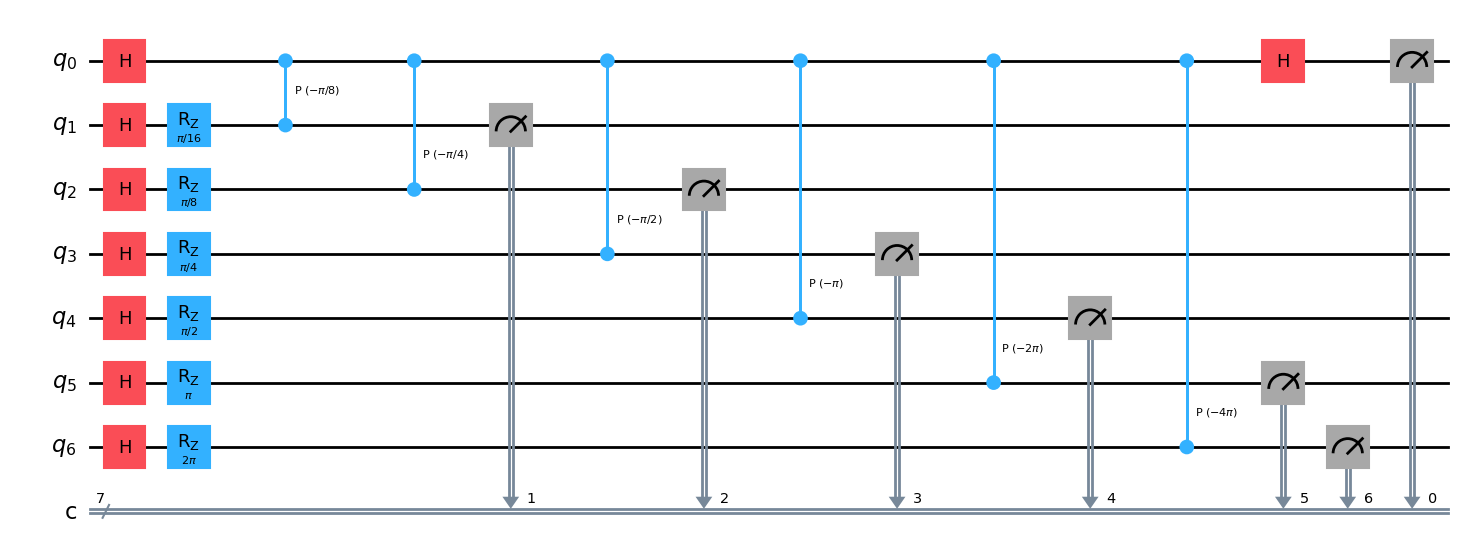

In [10]:
n = 6 # you can change the "resolution" here
k = 2*2*np.pi # you can change the "wavenumber" here
nshots = 2**15 # choose a high number of shots to reduce statistical noise

# qiskit circuit
qc = QuantumCircuit(n+1,n+1)
qc.h(0)
for nn in range(1,n+1):
    qc.h(nn)
    # apply a phase in a geometrical progression
    qc.rz(k/2**(n+1-nn), nn)
for nn in range(1,n+1):
    # uncompute double the phase
    qc.cp(-k/2**(n+1-nn)*2, 0, nn)
qc.h(0)
for nn in range(n+1):
    qc.measure(nn,nn)

qc.draw('mpl')

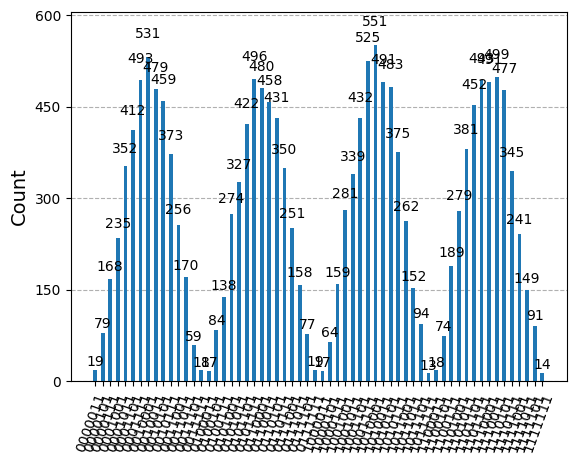

In [11]:
# Let's see the results!
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=nshots).result()
answer = result.get_counts()
answer_sorted = dict(sorted(answer.items(), key=operator.itemgetter(0)))

# filter results according to measured auxiliary qubit
lst_sin = {}
lst_cos = {}
for item,itemc in answer_sorted.items():
    if item[-1] == '0':
        lst_cos[item] = itemc
    if item[-1] == '1':
        lst_sin[item] = itemc
plot_histogram(lst_sin) # try to plot lst_cos as well

### Hadamard test
> Proof of circuit to compute the real part of $\langle 0|U|0 \rangle$. Check also the pre-print: https://arxiv.org/abs/2402.14156

Here we convert the unitary into "matrix" form, then convert it back to a controlled "quantum gate".

Hadamard Test:
 random unitary U:
 [[ 0.38560381-0.09135994j  0.91580184-0.06534573j]
 [ 0.38229219-0.8347549j  -0.22075916+0.32909319j]]
Real part of <0|U|0> (qiskit): 0.387786865234375
Real part of <0|U|0> (NumPy): 0.38560380673590866


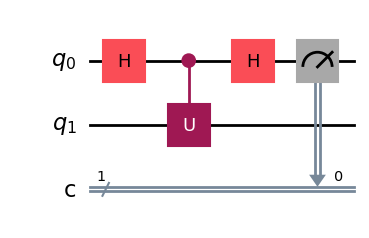

In [13]:
# confirm structure of the Hadamard test for a random unitary U
nshots = 2**16

# Step 1: Generate a random 1-qubit unitary U
U = random_unitary(2).data  # Random 1-qubit unitary matrix

# Step 2: Build the quantum circuit for the Hadamard test
circuit = QuantumCircuit(2, 1)  # 1 ancillary qubit + 1 working qubit, 1 classical bit

# Initialize ancillary qubit in |+>
circuit.h(0)

# Controlled-U operation
controlled_U = UnitaryGate(U, label="U").control(1)  # Create controlled version of U
circuit.append(controlled_U, [0, 1])  # Control on qubit 0, target qubit 1

# Final Hadamard gate on ancillary qubit
circuit.h(0)

# Measurement of ancillary qubit
circuit.measure(0, 0)

# Step 3: Simulate the circuit
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit, shots=nshots).result()
counts = result.get_counts()

# Post-process results
p0 = counts.get('0', 0) / nshots  # Probability of measuring '0'
p1 = counts.get('1', 0) / nshots  # Probability of measuring '1'
real_part = (p0 - p1)  # Real part of <0|U|0>

print("Hadamard Test:\n random unitary U:\n", U)
print("Real part of <0|U|0> (qiskit):", real_part)

# Step 4: Confirm <0|U|0> with numpy matrices
ket_0 = np.array([[1], [0]])  # |0> state
bra_0 = np.array([[1, 0]])    # <0| state
expectation_value = (bra_0 @ U @ ket_0).item()  # <0|U|0>
real_part_numpy = np.real(expectation_value)    # Real part
print("Real part of <0|U|0> (NumPy):", real_part_numpy)

# Display circuit
circuit.draw('mpl')

# exercise: modify circuit to measure imaginary part

### [§3. Useful tools for Physics:](#section3)

Outline:
- **Finite-Differences**: _incrementer/decrementer_ circuits: check unitary matrix. how it can apply discrete shifts on the quantum register.
  > Shift or rotate register: ```np.roll()```
- **Hamiltonian Simulation**: matrix exponential of Hamiltonians to get unitary evolution matrix
  > Tensor product to build multi-qubit wavefunctions and operators: ```np.kron()```
- **Moments**: measuring $\langle x \rangle$ and $\langle x^2 \rangle$ of quantum states
  > Decompose observable into Pauli strings
- **Distance between quantum states**: example of measuring overlap between 2 wavefunctions
  > Measure $|\langle \psi_2 | \psi_1 \rangle|^2$
- **2D wavefunction**: (no correlation) https://github.com/RePlasma/QuantumGaussianMomenta/blob/main/2Dgaussian.ipynb Loading
  > Requires StateVector and reshaping of the D>1 array: `Statevector.from_instruction(qc)` and `np.reshape()`
- **Variational circuits**: loading parameters methods https://github.com/RePlasma/q-2019-10-07-191/blob/main/q-2019-10-07-191.ipynb

### Finite-Differences
> Incrementer/Decrementer circuit. Check also [here](https://github.com/RePlasma/QuantumAdderIncrementer/blob/main/QuantumAdderIncrementer.ipynb)

With Finite-Differences, derivatives can for example be approximated as $\partial_x \sim (V_+- V_-)/(2\Delta)$, where $V_\pm$ select the nearest neighbor entries of a vector.

numpy matrix [[0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]]
qiskit matrix [[0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]]
same matrix? True


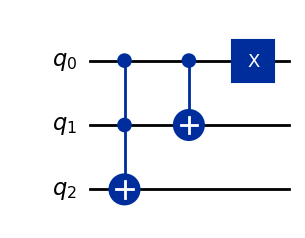

In [14]:
# incrementer circuit
n = 3

# numpy matrix
Id = np.eye(2**n)
U_numpy = np.roll(Id,+1,axis=0)
print("numpy matrix", np.int32(U_numpy) )

# qiskit circuit
qreg_q = QuantumRegister(3, 'q')
qc = QuantumCircuit(qreg_q)
qc.ccx(qreg_q[0],qreg_q[1],qreg_q[2])
qc.cx(qreg_q[0],qreg_q[1])
qc.x(qreg_q[0])
# retrieve unitary matrix
U_qiskit = Operator(qc).data
print("qiskit matrix", np.int32( np.real(U_qiskit) ))

# compare unitaries
print("same matrix?", np.allclose(U_qiskit, U_numpy))

# print circuit
qc.draw("mpl")

numpy matrix [[0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0]]
qiskit matrix [[0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0]]
same matrix? True


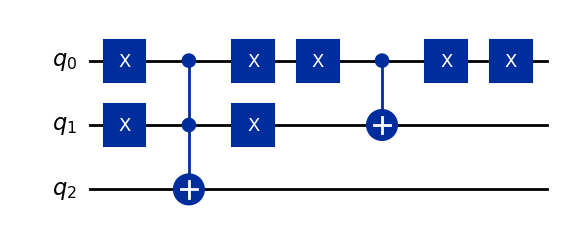

In [15]:
# decrementer circuit
n = 3

# numpy matrix
Id = np.eye(2**n)
U_numpy = np.roll(Id,-1,axis=0)
print("numpy matrix", np.int32(U_numpy) )

# qiskit circuit
qreg_q = QuantumRegister(3, 'q')
qc = QuantumCircuit(qreg_q)
qc.x(qreg_q[0])
qc.x(qreg_q[1])
qc.ccx(qreg_q[0],qreg_q[1],qreg_q[2])
qc.x(qreg_q[0])
qc.x(qreg_q[1])
qc.x(qreg_q[0])
qc.cx(qreg_q[0],qreg_q[1])
qc.x(qreg_q[0])
qc.x(qreg_q[0])
# retrieve unitary matrix
U_qiskit = Operator(qc).data
print("qiskit matrix", np.int32( np.real(U_qiskit) ))

# compare unitaries
print("same matrix?", np.allclose(U_qiskit, U_numpy))

# print circuit
qc.draw("mpl")

# exercise: confirm the two unitaries/circuits are inverse of each other, and generalize the circuits to n-qubits

### Hamiltonian Simulation $H=Z^{\otimes n}$
> Careful with the definition of the PhaseGate in qiskit: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PhaseGate

same matrix? True


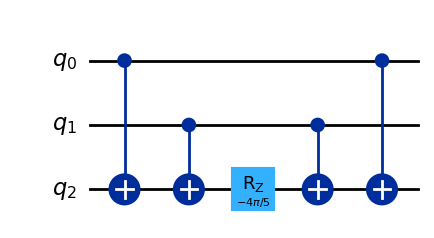

In [16]:
def generate_U_Pauli(phi, n=2):
    """Create a quantum circuit for U = exp(-1j * H * phi) with H = Z⊗Z."""
    qc = QuantumCircuit(n+1)
    # Define the Hamiltonian H = Z⊗Z
    H = SparsePauliOp(["Z"*n], coeffs=[1.0])
    # Create the unitary evolution gate
    U_gate = PauliEvolutionGate(H, time=phi)
    # Apply the gate to the circuit
    qc.append(U_gate, list(range(n)))
    return qc

def generate_U_manual(phi, n=2):
    """Manually implement U = exp(-1j * Z⊗... * phi) using CX and RZ gates."""
    # Apply controlled phase rotation to implement e^{-i Z^n phi}
    qc = QuantumCircuit(n+1)
    for j in range(n):
        qc.cx( j, n )
    # apply qubit phase
    qc.rz( -2*phi, n ) # -2*phi accounts for exp(-i Z phi) structure
    for j in range(n):
        qc.cx( n-j-1, n )
    return qc


# Example usage
n = 2
phi = np.pi * 0.4

qc_Pauli = generate_U_Pauli(phi, n=n)
U_Pauli = (Operator(qc_Pauli).data)
#
qc_manual = generate_U_manual(phi, n=n)
U_manual = (Operator(qc_manual).data)

print("same matrix?", np.allclose( np.real(U_Pauli), np.real(U_manual) ))

qc_manual.draw('mpl')

### Moments of distribution functions
> Suppose you want to measure the mean or spread of a wavefunction

This decomposition allows us to extract the moments of a wavefunction relatively efficiently. At most requires 2-qubit Pauli-terms measurements. All Pauli terms commute, which probably means very efficient parallel measurement protocol.


Pauli-string decomposition of moment observables:
$$
\hat{x} = \frac{1}{2}(2^n - 1) \, I - \frac{1}{2} \sum_{i=0}^{n-1} 2^{n - i - 1} Z_i
$$

$$
\hat{x}^2 = \left( a^2 + \sum_{i=0}^{n-1} b_i^2 \right) \, I + 2a \sum_{i=0}^{n-1} b_i Z_i + 2 \sum_{0 \leq i < j \leq n-1} b_i b_j \, Z_i Z_j
$$

with $a = \frac{1}{2}(2^n - 1), b_i = -\frac{1}{2} \times 2^{n - i - 1}$

In practice, one would then need to measure the Pauli-string terms such that $\langle x\rangle = \langle \psi|\hat{x}|\psi\rangle, \langle x^2\rangle = \langle \psi|\hat{x}^2|\psi\rangle$

In [17]:
def construct_Z_i(i, n):
    """
    Construct the Z_i operator acting on n qubits, with qubits ordered from MSB to LSB.
    """
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I2 = np.identity(2, dtype=complex)
    operators = [I2] * n
    operators[i] = Z  # Place Z at position i
    return kron_n(operators)

def construct_Z_iZ_j(i, j, n):
    """
    Construct the Z_i Z_j operator acting on n qubits.
    """
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I2 = np.identity(2, dtype=complex)
    operators = [I2] * n
    operators[i] = Z  # Place Z at position i
    operators[j] = Z  # Place Z at position j
    return kron_n(operators)

def kron_n(operators):
    """
    Compute the Kronecker product of a list of operators.
    """
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def compute_x_ps(n):
    """
    Compute the Pauli string decomposition of x for n qubits.
    """
    dim = 2 ** n
    I = np.identity(dim, dtype=complex)
    a = 0.5 * (2 ** n - 1)
    x_ps = a * I
    for i in range(n):
        b_i = -0.5 * 2 ** (n - i - 1)
        Z_i = construct_Z_i(i, n)
        x_ps += b_i * Z_i
    return x_ps

def compute_x_ps2(n):
    """
    Compute the Pauli string decomposition of x^2 for n qubits.
    """
    dim = 2 ** n
    I = np.identity(dim, dtype=complex)
    a = 0.5 * (2 ** n - 1)
    x_ps2 = (a ** 2) * I
    # Add b_i^2 terms
    for i in range(n):
        b_i = -0.5 * 2 ** (n - i - 1)
        x_ps2 += (b_i ** 2) * I
    # Add 2a b_i Z_i terms
    for i in range(n):
        b_i = -0.5 * 2 ** (n - i - 1)
        Z_i = construct_Z_i(i, n)
        x_ps2 += 2 * a * b_i * Z_i
    # Add 2 b_i b_j Z_i Z_j terms
    for i in range(n):
        b_i = -0.5 * 2 ** (n - i - 1)
        for j in range(i + 1, n):
            b_j = -0.5 * 2 ** (n - j - 1)
            Z_iZ_j = construct_Z_iZ_j(i, j, n)
            x_ps2 += 2 * b_i * b_j * Z_iZ_j
    return x_ps2

def compute_x_operator(n):
    """
    Construct the x operator as a diagonal matrix.
    """
    dim = 2 ** n
    x_values = []
    for i in range(dim):
        bits = [int(b) for b in format(i, '0' + str(n) + 'b')]
        # bits are ordered from MSB to LSB
        x_i = sum(bits[j] * 2 ** (n - j - 1) for j in range(n))
        x_values.append(x_i)
    x_operator = np.diag(x_values)
    return x_operator

In [18]:
n = 4  # Number of qubits
print(f"Number of qubits: n = {n}")

# Compute x operator directly
x_operator = compute_x_operator(n)

# Compute x^2 operator directly
x2_operator = np.dot(x_operator, x_operator)

# Compute Pauli string decomposition of x
x_ps = compute_x_ps(n)

# Compute Pauli string decomposition of x^2
x_ps2 = compute_x_ps2(n)

# Verify that x_operator and x_ps are equal
diff_x = np.allclose(x_operator, x_ps)
print(f"The decomposition of x is {'correct' if diff_x else 'incorrect'} for n = {n}.")

# Verify that x2_operator and x_ps2 are equal
diff_x2 = np.allclose(x2_operator, x_ps2)
print(f"The decomposition of x^2 is {'correct' if diff_x2 else 'incorrect'} for n = {n}.")

# Optional: Display diagonal entries of x and x^2
print("Diagonal entries of x:", np.diag(x_operator))
print("Diagonal entries of x^2:", np.diag(x2_operator))

# exercise: apply this to a gaussian and confirm average and spread (need to choose a coordinate "domain")

Number of qubits: n = 4
The decomposition of x is correct for n = 4.
The decomposition of x^2 is correct for n = 4.
Diagonal entries of x: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Diagonal entries of x^2: [  0   1   4   9  16  25  36  49  64  81 100 121 144 169 196 225]


### Distance between quantum states
> How to measure the overlap $\langle \psi_1 | \psi_2 \rangle$ between 2 quantum states $\psi_1, \psi_2$? Check also [here](https://github.com/RePlasma/New_J._Phys._20_113022)

In this paper they use ML to find more compact quantum circuits to perform the same task: https://iopscience.iop.org/article/10.1088/1367-2630/aae94a

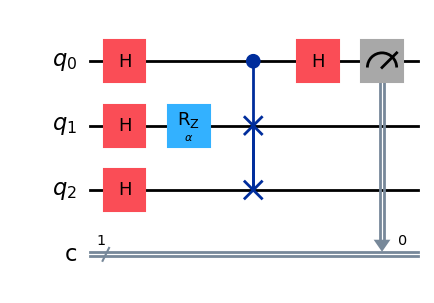

In [19]:
# SWAP
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(1, 'c')
qc_swap = QuantumCircuit(qr,cr)

# rho
qc_swap.h(1)
alpha_swap = Parameter(r'$\alpha$')
qc_swap.rz(alpha_swap,1)
# sigma
qc_swap.h(2)

qc_swap.h(0)
qc_swap.cswap(0,1, 2)
qc_swap.h(0)
qc_swap.measure(0,0)
qc_swap.draw(output='mpl')

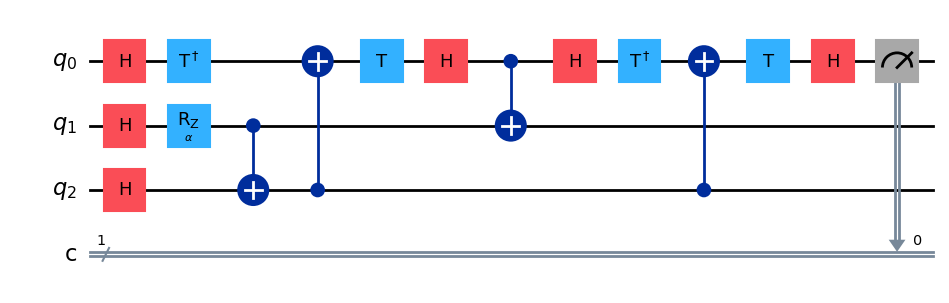

In [20]:
# ABA
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(1, 'c')
qc_aba = QuantumCircuit(qr,cr)

# rho
qc_aba.h(1)
alpha_aba = Parameter(r'$\alpha$')
qc_aba.rz(alpha_aba,1)
# sigma
qc_aba.h(2)

qc_aba.h(0)
qc_aba.tdg(0) #T*
qc_aba.cx(1,2)
qc_aba.cx(2,0)
qc_aba.t(0) #T
qc_aba.h(0)
qc_aba.cx(0,1)
qc_aba.h(0)
qc_aba.tdg(0) #T*
qc_aba.cx(2,0)
qc_aba.t(0) #T
qc_aba.h(0)

qc_aba.measure(0,0)
qc_aba.draw(output='mpl')

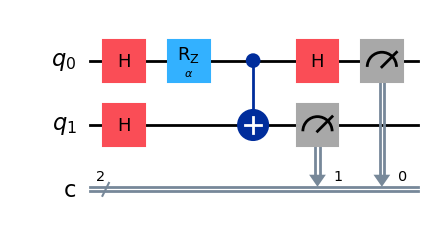

In [21]:
# BBA
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
qc_bba = QuantumCircuit(qr,cr)

# rho
qc_bba.h(0)
alpha_bba = Parameter(r'$\alpha$')
qc_bba.rz(alpha_bba,0)
# sigma
qc_bba.h(1)

qc_bba.cx(0,1)
qc_bba.h(0)
qc_bba.measure(0,0)
qc_bba.measure(1,1)
qc_bba.draw(output='mpl')

In [23]:
nshots = 2**10

# parameter scan
alpha_lst = np.linspace(0,2*np.pi,20)
ov_th = np.cos(alpha_lst/2)**2

#
ov_lst_swap = np.zeros(len(alpha_lst))
ov_lst_aba = np.zeros(len(alpha_lst))
ov_lst_bba = np.zeros(len(alpha_lst))

for i in range(len(alpha_lst)):
    ### swap
    # assign value to parameter
    qc = qc_swap.assign_parameters({alpha_swap: alpha_lst[i]})
    # sample measurements
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=nshots).result()
    ibm_res_swap = result.get_counts()

    ### aba
    # assign value to parameter
    qc = qc_aba.assign_parameters({alpha_aba: alpha_lst[i]})
    # sample measurements
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=nshots).result()
    ibm_res_aba = result.get_counts()

    ### bba
    # assign value to parameter
    qc = qc_bba.assign_parameters({alpha_bba: alpha_lst[i]})
    # sample measurements
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=nshots).result()
    ibm_res_bba = result.get_counts()

    ### post-process

    # swap
    p0 = 0;
    if '0' in ibm_res_swap:
        p0 = ibm_res_swap['0']/nshots
    ov_lst_swap[i] = 2*p0-1

    ## aba
    p0 = 0; p1 = 0;
    if '0' in ibm_res_aba:
        p0 = ibm_res_aba['0']/nshots
    if '1' in ibm_res_aba:
        p1 = ibm_res_aba['1']/nshots
    ov_lst_aba[i] = p0-p1

    ## bba
    p00 = 0; p01 = 0; p10 = 0; p11 = 0;
    if '00' in ibm_res_bba:
        p00 = ibm_res_bba['00']/nshots
    if '01' in ibm_res_bba:
        p01 = ibm_res_bba['01']/nshots
    if '10' in ibm_res_bba:
        p10 = ibm_res_bba['10']/nshots
    if '11' in ibm_res_bba:
        p11 = ibm_res_bba['11']/nshots
    ov_lst_bba[i] = p00 + p01 + p10 - p11

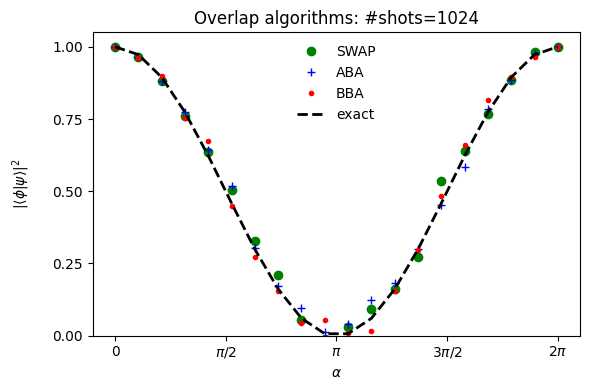

In [24]:
# plot reproducing FIG2
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(alpha_lst, ov_lst_swap,'go', label='SWAP', linewidth=3)
plt.plot(alpha_lst, ov_lst_aba,'b+', label='ABA', linewidth=3)
plt.plot(alpha_lst, ov_lst_bba,'r.', label='BBA', linewidth=3)
plt.plot(alpha_lst, ov_th,'k--', label='exact', linewidth=2)
plt.ylim([0,1.05])

axes.set_xlabel(r'$\alpha$')
axes.set_ylabel(r'$|\langle \phi | \psi \rangle|^2$',labelpad=15)
axes.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi])
axes.set_xticklabels([r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
axes.set_yticks([0,0.25,0.5,0.75,1])
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
#axes.set_aspect(aspect=4/3/axesratio)
plt.legend(loc='upper center', frameon=False)
plt.title(r'Overlap algorithms: #shots={}'.format(nshots))
plt.tight_layout()
plt.show()

# exercise: generalize to n-qubits, add noise model and check which algorithm is more robust to noise

### Preparing a "2D" wavefunction
> Conceptually, a 2D or 3D array has to be converted into a 1D quantum state to fit the quantum circuit. This is the same idea in classical ODE/PDE solvers, when we convert the D>1 domain into a single matrix equation: https://en.wikipedia.org/wiki/Discrete_Poisson_equation

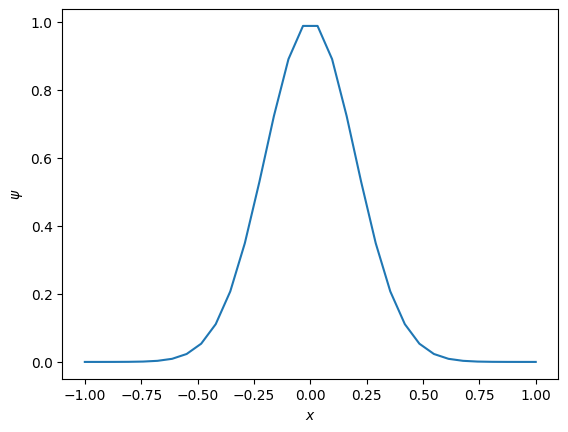

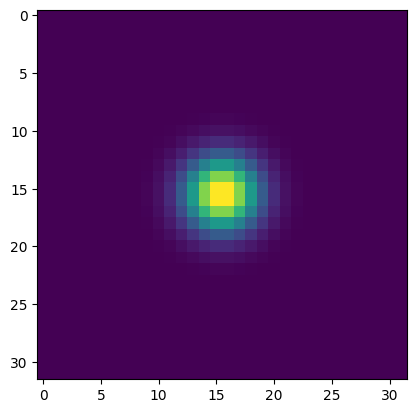

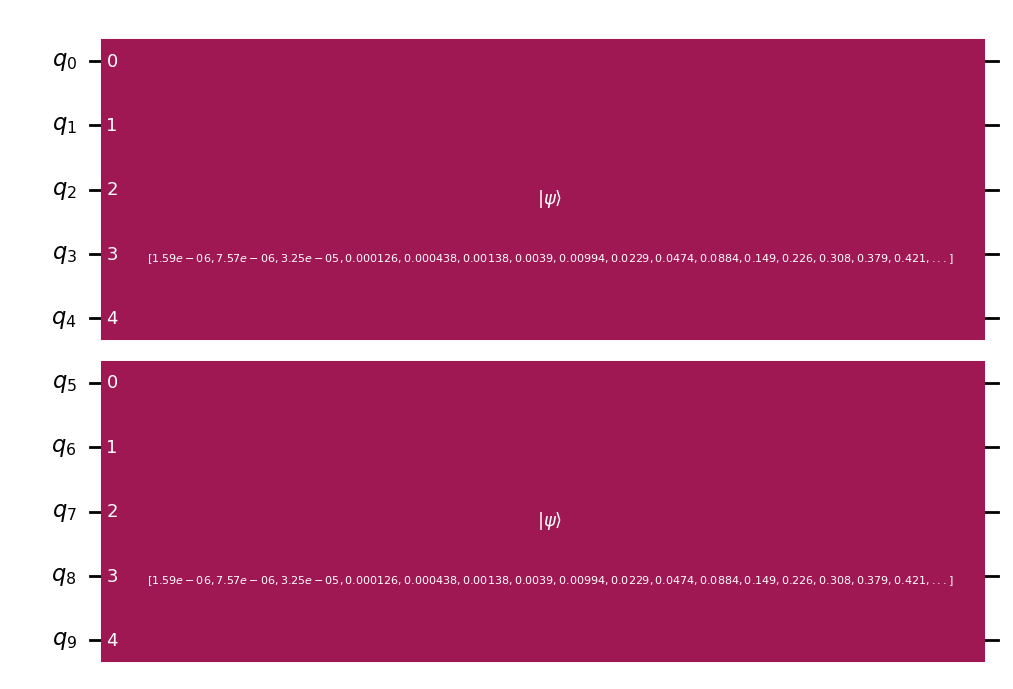

In [25]:
n = 5
mu0 = 0
sigma0 = 0.2 # spread
xlst = np.linspace(-1,+1,2**n) # coordinate space

psi0 = exp(-0.5*( (xlst-mu0)/sigma0 )**2)
plt.plot(xlst, psi0)
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi$')
plt.show()

# start quantum circuit
qc = QuantumCircuit(2*n)
# load psi0 into each register
qc.initialize(psi0, list(range(0,n)), normalize=True)
qc.initialize(psi0, list(range(0+n,n+n)), normalize=True)

# retrieve "wavefunction"
psi = Statevector.from_instruction(qc)
# get probabilities
psi2 = np.abs(np.array(psi))**2
# reshape array
psi2 = psi2.reshape((2**n,2**n))
# plot probs
plt.imshow(psi2)
plt.show()

# show circuit
qc.draw('mpl')

# exercise: modify the code to load an assymmetric state, with different mean positions and sigmas along x and y directions

### [§4. Computational Physics:](#section4)
> Concrete applications to physics problems

- Schrödinger equation: https://github.com/linigoga/QuantumSchrodingerEquation/blob/main/QuantumSimBenenti.ipynb
  > Free-particle and Quantum Harmonic Potential
- Advection equation: https://github.com/RePlasma/PhysRevResearch.6.033246/blob/main/PhysRevResearch.6.033246.ipynb
  > Important for Fluid Dynamics
- Heat equation: https://github.com/OsAmaro/QuantumFokkerPlanck/blob/main/Heat_analytical_MVP.ipynb
  > simplest diffusive/stochastic process, but non-native to quantum computers because of non-unitarity
- Comparison between Schrödinger and Heat equations: https://github.com/OsAmaro/QuantumFokkerPlanck/blob/main/Heat_vs_Schrodinger.ipynb


In [ ]:
### code here

### [§5. WPD:](#section5)
> Extracting data from plots with [WebPlotDigitizer v4](https://apps.automeris.io/wpd4/)
- Open-science, open-source.
- Example of GoLP's repositories on [Zenodo](https://zenodo.org/communities/golp/records?q=&l=list&p=1&s=10&sort=newest)
- Workflow:
    - Choose a figure from a paper and save it as a png
    - Uploade the figure to WPD
    - Align axes, select color, sampling rate, pen tools, squares
    - Save the results as ```.csv``` for each dataset or download the whole project as a ```.tar``` file, which can be reuploaded to WPD

In [ ]:
###
"""
# assuming there is a local folder dataWPD
f = open('dataWPD/fig1/wpd.json')
data = json.load(f)

# load dataset 0
datatmp = data['datasetColl'][0]['data']
# convert to numpy array
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))]);
# sort points by x-value
indxs = np.argsort(datatmp2[:,0])
x, y = datatmp2[:,0][indxs], datatmp2[:,1][indxs]
# plot
plt.plot(x, y, 'o', label=r'WPD')
"""
print()

## [§6. Exercise:](#section6)
> Try to use some of the techniques to solve the following problem.
- Brief intro: 3 and 4-wave mixing, a very common process in physics
- Extract data
    - Download pre-print https://arxiv.org/abs/2004.06885 "Simulating nonnative cubic interactions on noisy quantum machines"
    - Use WebPlotDigitizer to extract data from the orange lines in figure 2. Save each subplot as a different ```.tar```, or define 3 different axes in the same project.
- Numpy
    - Implement the Hamiltonian $h$ from equation 11 as a Numpy array matrix. You can expand it to be a 4x4 matrix, with entry 4,4 equal to 0.
    - Use Scipy's expm to confirm that the matrix exponential of the Hamiltonian is compatible with the unitary matrix in equation S.1
    - Create initial state for occupations of figure 2. Apply the unitary matrix for 100 steps. Save the "occupations", that is the |amplitudes|^2, and compare result with the WPD data.
- Qiskit
    - Check Figure S1 of the paper. Implement the quantum operations on the online composer.
    - Optional:
        - You can use the IBMQ composer https://quantum.ibm.com/composer, and create an IBM Quantum account https://quantum.ibm.com/
        - After the circuit is complete, save the circuit. Go to the tab /Composer Files, and Download the project. Unzip folder and locate the .qasm file
        - Go to https://docs.quantum.ibm.com/api/qiskit/qasm3 and read how to import the qasm file into qiskit
        - Import the file within a Jupyter notebook and confirm circuit is ok.
    - Use ```qiskit_aer``` or [Statevector](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Statevector) to run circuit and compare result of simulation with the other approaches. You'll need to define a new circuit with increasing depth for each N times.


- Extra:
    - Measure $<x>$ and $<x^2>$ of the state in time, using proper quantum circuits and quantum measurement operations in qiskit.
    - Use the overlap circuit to compute with qiskit the “fidelity”, that is, the overlap between the state after some number of steps N and the initial state $\langle \psi(t)| \psi(0) \rangle$ (you’ll need to duplicate the register). Confirm result with Numpy.

In [ ]:
### code here

### [7. Conclusions:](#section7)
> Further reading and quantum technologies-related events

The textbook "Quantum Computation and Quantum Information" (available to borrow at [BIST](https://bist.tecnico.ulisboa.pt/)): https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview

Resources (there’s a lot more to learn than this tutorial!):
- “1 Minute Qiskit” tutorials on Youtube: https://www.youtube.com/playlist?list=PLOFEBzvs-VvpOCmJ9BonUhf7NYB4d1p0e
- List of learning resources: https://www.quantumcoalition.io/learning-resources-wip

Events:
- Year of Quantum 2025: https://quantum2025.org/
- Calendar of Quantum events (summer-schools, hackathons, workshops): https://quantiki.org/calendar-node-field-dates

European efforts:
- Quantum Flagship: https://qt.eu/events/
- myQLM (alternative to qiskit): https://myqlm.github.io/
- Quantum Internet Alliance: https://quantuminternetalliance.org/

In Portugal:
- Portuguese Quantum Ecosystem: https://www.quantum2025.pt/ecossistema
- PQI: https://pqi.pt/